<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## Project: Evolution of Agents

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

# Outline

1. [Reinforcement Learning](#rl)
2. [Evolving Agents](#evolving)
3. [Atari games](#atari)
4. [CGP](#cgp)
5. [Neuroevolution](#neuroevo)
6. [Comparison](#comparison)

In this project, you have been asked to evolve an agent to play a video game. In this notebook, we'll see an example of that as well as a brief explanation on agent evolution.

# <a id="rl"></a> Reinforcement Learning

The field of Reinforcement Learning provides a good framework for understanding the actions of an agent in an environment which rewards specific actions. There are many resources about RL online, including Emmanuel Rachelson's [class](https://github.com/erachelson/RLclass) which is taught in the SDD Master's program at Supaero. We'll look at a brief overview as it relates to evolution.

In RL, an agent acts based on a policy $\pi$, which uses state information $S_t$ to take an action $A_t$. Based on this action, the environment rewards the agent $R_{t+1}$ and the agent moves into a new state $S_{t+1}$. 

<img src="../imgs/erl.png" width="35%">

The standard objective function for an evolutionary algorithm when applied to this problem is the sum total of the reward over all timesteps in an episode, from $t=0$ to the end of the episode $t=T$.

$$\sum_{t=0}^{t=T} R_{t}$$

In other words, evolution is aiming to maximize the total reward over all states $S$ observed and actions $A$ taken  during this episode. The set of states observed and actions taken depends on the current individual $\pi$ (or policy), where an action $a$ for a given state $s$ is determined by $a=\pi(s)$. A different way to write the objective function is:

$$\sum_{t=0}^{t=T} r(s_t, \pi(s_t))$$

where $r$ is the reward function of the problem. The optimization of the total reward over the entire episode is very different from Reinforcement Learning algorithms, which maximize the reward over individual state, action $(S,A)$ pairs and many of which aim to approximate $r$. In most evolutionary computation, all that matters is the total reward.

<div class="alert alert-warning">
    <h3>Reminder</h3>
    
In an evolutionary algorithm, the total reward is not the only fitness objective possible. Quality diversity algorithms like MAP-Elites use behavior metrics which measure a different objective than reward over an episode. Using total reward is a good way to compare evolutionary methods to Reinforcement Learning algorithms, but it is not the only option for evolutionary fitness functions.
</div>

# <a id="evolving"></a>Evolving Agents

When evolving agents, there are many options for representing the agent. The agent needs only to be able to taken an action $a$ at every step $s$, in other words the agent is $\pi$ and we'll use the agent to compute $a=\pi(s)$. Any representation of a function is possible: a layered artificial neural network where weights are optimized by evolution; a complex ANN where structure and weights are evolved; a genetic program; a gene regulatory network; any evolvable function representation works!

<img src="../imgs/agent_representations.png" width="50%">

The evaluation of an individual is therefore a multi-step process. Given an individual's genes $G$, a phenotype $P$ is computed. The genes can take many forms, as can the phenotypes. One example is a binary gene regulatory network, where binary genes encode protein tags which inform the weights of the final network, which is the phenotype. Another is the integer genotype used in NEAT, which encodes neurons and their connections in the phenotype which is a neural network.

<img src="../imgs/gene_pheno_behavior.png" width="70%">

 For evaluation, $P$ must be capable of representing a function $\pi$ which computes $a=\pi(s)$ or sometimes $a_t=\pi(s_t, r(s_{t-1}, a_{t-1}))$, where the reward from the previous step is also provided. The evaluation of the agent which informs its chances of passing on genetic information is then based on its behavior in a simulated environment.

In this notebook, we'll compare Cartesian Genetic Programming, where our agent is a function graph, and neuroevolution, using a $(1, \lambda)$ evolutionary strategy to evolve the weights of a 2 layer neural network. We'll use Atari games as the environment, specifically Ms. Pacman.

# <a id="atari"></a> Atari games

For a game environment, we'll use the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment), which allows us to emulate and manipulate Atari games. There is a [Julia wrapper](https://github.com/JuliaReinforcementLearning/ArcadeLearningEnvironment.jl) which I've only tested on Linux, although the [atari-py](https://github.com/openai/atari-py) package mentions Windows support

In [1]:
using Pkg
pkg"add ArcadeLearningEnvironment"

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


g: [========================================>]  100.0 %

   Updating registry at `~/.julia/registries/LyceumRegistry`
   Updating git-repo `https://github.com/Lyceum/LyceumRegistry`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


This package automatically installs a number of ROMs from the `atari-py` repository

In [2]:
using ArcadeLearningEnvironment
ale = ALE_new()

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.


Ptr{Nothing} @0x000055d441944550

In [3]:
getROMList()

63-element Array{String,1}:
 "adventure"
 "air_raid"
 "alien"
 "amidar"
 "assault"
 "asterix"
 "asteroids"
 "atlantis"
 "bank_heist"
 "battle_zone"
 "beam_rider"
 "berzerk"
 "bowling"
 ⋮
 "solaris"
 "space_invaders"
 "star_gunner"
 "tennis"
 "time_pilot"
 "tutankham"
 "up_n_down"
 "venture"
 "video_pinball"
 "wizard_of_wor"
 "yars_revenge"
 "zaxxon"

We'll look at  Ms. Pacman as an example. Instead of using the entire action set, we'll only use the actions available in this game. Since the "fire" button isn't used in Ms. Pacman, the only actions are the 8 directions from the joystick and no input.

In [4]:
loadROM(ale, "ms_pacman")
actions = getMinimalActionSet(ale)

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


9-element Array{Int64,1}:
 0
 2
 3
 4
 5
 6
 7
 8
 9

Let's see what the environment looks like.

In [5]:
using Images, ImageView
function get_screen(ale)
    screen = reshape(getScreenRGB(ale), (3, getScreenWidth(ale), getScreenHeight(ale))) ./ 256
    colorview(RGB, permutedims(screen, [1, 3, 2]))
end

get_screen (generic function with 1 method)

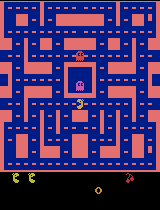

In [6]:
get_screen(ale)

Let's watch the environment as our agent takes random actions.

In [7]:
using Reel
Reel.set_output_type("gif");

In [8]:
loadROM(ale, "ms_pacman")
frames = Frames(MIME("image/png"), fps=60)
total_reward = 0
while ~game_over(ale)
    total_reward += act(ale, rand(actions))
    push!(frames, get_screen(ale))
end
reset_game(ale)

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


In [9]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_rvYtBQ", 0x0000000000000809, 60.0, nothing)

For the state of our environment, we have two options: the pixels, as we saw in the [class on CGP](https://d9w.github.io/evolution/4_gp/2_cgp.html), and the RAM, the memory of the game. We'll use the RAM in this example since it is much smaller and evolution will be faster since we don't need to get the screen every step.

In [10]:
loadROM(ale, "ms_pacman")

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


In [11]:
getRAM(ale)

128-element Array{UInt8,1}:
 0x00
 0x70
 0x72
 0x73
 0x00
 0x03
 0x58
 0x58
 0x58
 0x58
 0x58
 0x00
 0x50
    ⋮
 0x00
 0x3f
 0x00
 0x00
 0x00
 0x00
 0x00
 0x02
 0x42
 0xf0
 0x92
 0xd7

# <a id="cgp"></a>CGP

Let's evolve our first agent. We'll use `Cambrian.jl` and `CartesianGeneticProgramming.jl` to evolve a function graph using CGP which takes in the RAM values and outputs a value per action, which we'll use the maximum of to determine the action at each step.

In [12]:
pkg"add https://github.com/d9w/Cambrian.jl"
pkg"add https://github.com/d9w/CartesianGeneticProgramming.jl"

   Updating git-repo `https://github.com/d9w/Cambrian.jl`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


   Updating git-repo `https://github.com/d9w/CartesianGeneticProgramming.jl`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [13]:
using Cambrian
using CartesianGeneticProgramming

An example configuration for CGP on this problem is provided in `atari.yaml`. This specifies which functions CGP can choose from, how many rows and columns there are, and what the mutation rate is.

In [14]:
cfg = get_config("atari.yaml")
cfg["n_in"] = length(getRAM(ale))
cfg["n_out"] = length(actions)
cfg

Dict{Any,Any} with 15 entries:
  "two_arity"    => Bool[1, 1, 1, 0, 0, 0, 1, 1]
  "n_in"         => 128
  "m_rate"       => 0.1
  "functions"    => Function[f_add, f_subtract, f_mult, f_abs, f_exp, f_sin, f_…
  "d_fitness"    => 1
  "save_gen"     => 10
  "out_m_rate"   => 0.3
  "n_out"        => 9
  "n_elite"      => 1
  "n_population" => 5
  "rows"         => 3
  "n_gen"        => 1000
  "seed"         => 0
  "columns"      => 100
  "log_gen"      => 1

We'll define our objective function allowing us to also use this function to visualize an agent as it plays.

In [15]:
cgp_fits = []
function play_atari(ind::CGPInd; render=false, seed=0)
    ale = ALE_new()
    loadROM(ale, "ms_pacman")
    if render
        frames = Frames(MIME("image/png"), fps=6)
    end
    f = 0
    total_reward = 0
    while ~game_over(ale) && f < 18000
        inputs = getRAM(ale) ./ typemax(UInt8)
        output = process(ind, inputs)
        total_reward += act(ale, actions[argmax(output)])
        if render && mod(f, 10) == 0
            push!(frames, get_screen(ale))
        end
        f += 1
    end
    ALE_del(ale)
    if render
        return total_reward, frames
    end
    push!(cgp_fits, total_reward)
    [total_reward]
end

play_atari (generic function with 1 method)

Let's see how a random individual does

In [16]:
ind = CGPInd(cfg);
@timev total_reward, frames = play_atari(ind; render=true)

  2.392936 seconds (1.49 M allocations: 470.896 MiB, 1.54% gc time)
elapsed time (ns): 2392935523
gc time (ns):      36755645
bytes allocated:   493770356
pool allocs:       1484736
non-pool GC allocs:332
malloc() calls:    1248
GC pauses:         7


A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


(70, Frames{MIME{Symbol("image/png")}}("/tmp/jl_ky5ywR", 0x00000000000000d0, 6.0, nothing))

In [17]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_ky5ywR", 0x00000000000000d0, 6.0, nothing)

The rendering evaluation took a while if we consider that during evolution, we'll run this function hundreds or thousands of times. Let's see how long it takes without rendering.

In [18]:
@timev total_reward = play_atari(ind)

  0.436167 seconds (120.26 k allocations: 4.810 MiB)
elapsed time (ns): 436166923
bytes allocated:   5043568
pool allocs:       120257


A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


1-element Array{Int64,1}:
 70

That's better. Let's run the evolution for 20 generations, evaluating 5 individuals each time ($\lambda$=5) for a total of 100 evaluations.

In [19]:
cgp_fits = []
evo = CartesianGeneticProgramming.evolution(cfg, play_atari);

In [20]:
for i in 1:20
    Cambrian.step!(evo)
end

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartr

Let's observe the best individual from evolution and display its actions.

In [21]:
best = sort(evo.population)[end];
total_reward, frames = play_atari(best, render=true)

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


(440, Frames{MIME{Symbol("image/png")}}("/tmp/jl_SpqiCR", 0x0000000000000104, 6.0, nothing))

In [22]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_SpqiCR", 0x0000000000000104, 6.0, nothing)

# <a id="neuroevo"></a> Neuroevolution

For our second approach, we'll evolve the weights of a neural network using the $(1, \lambda)$ evolutionary strategy we in the [evolutionary strategies tutorial](https://github.com/d9w/evolution/blob/master/5_strategies/1_ES.ipynb). For the neural network, we'll use [Flux](fluxml.ai) to define the neural network - we'll use a 2 layer network with (32, 16) neurons.

In [23]:
using Flux

In [24]:
n_in = length(getRAM(ale))
n_out = length(actions)
model = Chain(
    Dense(n_in, 32),
    Dense(32, 16),
    Dense(16, n_out))

Chain(Dense(128, 32), Dense(32, 16), Dense(16, 9))

We can test this neural network with some game inputs

In [25]:
model(getRAM(ale) ./ typemax(UInt8))

9-element Array{Float32,1}:
 -1.2712206
  1.0186182
  1.2801273
  0.96323484
  0.53524303
  0.39767325
  0.101335704
  1.4927574
  0.32735276

We need to redefine our Atari function to use a neural network.

In [26]:
function play_atari(model::Chain; render=false, seed=0)
    loadROM(ale, "ms_pacman")
    if render
        frames = Frames(MIME("image/png"), fps=6)
    end
    f = 0
    total_reward = 0
    while ~game_over(ale) && f < 18000
        inputs = getRAM(ale) ./ typemax(UInt8)
        output = model(inputs)
        total_reward += act(ale, actions[argmax(output)])
        if render && mod(f, 10) == 0
            push!(frames, get_screen(ale))
        end
        f += 1
    end
    reset_game(ale)
    if render
        return total_reward, frames
    end
    total_reward
end

play_atari (generic function with 2 methods)

Let's see how a random neural network plays

In [27]:
total_reward, frames = play_atari(model, render=true)
total_reward

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


70

In [28]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_PKEDZS", 0x00000000000000d5, 6.0, nothing)

We're not quite ready to evolve the weights, however. To do that, we need to make a function that transforms genes into a neural network. Let's see how many parameters our network has.

In [29]:
param_lengths = [length(p) for p in params(model)]

6-element Array{Int64,1}:
 4096
   32
  512
   16
  144
    9

In [30]:
ndims = sum(param_lengths)

4809

So we'll optimize 4809 genes and use them as the weights and biases of our neural network (the phenotype) to evaluate them. We need to defined a function that takes in the genes and returns a neural network with those genes and weights and biases.

In [31]:
function set_weights(x::Array{Float64})
    model = Chain(
        Dense(n_in, 32),
        Dense(32, 16),
        Dense(16, n_out))
    start = 1
    for p in params(model)
        p .= reshape(x[start:(start+length(p)-1)], size(p))
        start += length(p)
    end
    model
end

set_weights (generic function with 1 method)

Let's see if that worked. If we set all weights to 0, the output should always be 0.

In [32]:
model = set_weights(zeros(ndims))

Chain(Dense(128, 32), Dense(32, 16), Dense(16, 9))

In [33]:
model(rand(128))

9-element Array{Float32,1}:
 -238.71797
  329.18237
   -8.303442
  -48.278893
  108.821465
   81.84656
  -75.78077
  -17.442709
  325.28726

Now that we have our genotype to phenotype mapping function, we can create the objective function.

In [34]:
function objective(x::Array{Float64})
    model = set_weights(x)
    play_atari(model)
end

objective (generic function with 1 method)

Finally, we'll import the ES step function from the evolutionary strategies tutorial.

In [55]:
using Statistics
using LinearAlgebra
function step(x::Array{Float64}, objective::Function; npop=20, sigma=0.5, alpha=0.1)
    N = randn(npop, length(x))
    P = repeat(x, 1, npop)' .+ sigma .* N
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :])
    end
    A = (R .- mean(R)) ./ std(R)
        
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)], R, P
end

step (generic function with 1 method)

Let's create a random individual and see its performance.

In [56]:
x = rand(ndims);
objective(x)

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


60

Not great, but it'll do as a starting point. We'll run the first generation and get back $x$, the new center of our population, $R$, the array of all fitness values, and $P$, the population matrix.

In [57]:
x, R, P = step(x, objective);

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bi

Let's see what the best individual we found was. Note that this isn't our new $x$, its whichever individual we observed with the best fitness. $x$ should have moved in the direction of that individual's genes, but is also based on fitness values from the entire population.

In [58]:
(maximum(R), argmax(R))

(90.0, 1)

We'll run this for 4 more generations, keeping track of the best individual each generation.

In [59]:
es_fits = []
append!(es_fits, R)
best_ind = P[argmax(R), :]
best_fit = maximum(R)

90.0

In [60]:
for i in 2:5
    x, R, P = step(x, objective)
    append!(es_fits, R)
    if maximum(R) > best_fit
        best_fit = maximum(R)
        best_ind .= P[argmax(R), :]
    end
    println(best_fit, length(es_fits))
end

280.040
280.0

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bi

60


Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bi

280.080
280.0

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bi

100


Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bi

Once that's done, let's see how our best individual does

In [61]:
model = set_weights(best_ind)
total_reward, frames = play_atari(model, render=true)

Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


(280, Frames{MIME{Symbol("image/png")}}("/tmp/jl_sIvnCR", 0x00000000000000ce, 6.0, nothing))

In [62]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_sIvnCR", 0x00000000000000ce, 6.0, nothing)

# <a id="comparison"></a> Comparison

Now that we have run two different evolutionary methods, we can compare them. Let's look at all 100 evaluations for both method.

In [67]:
using Plots

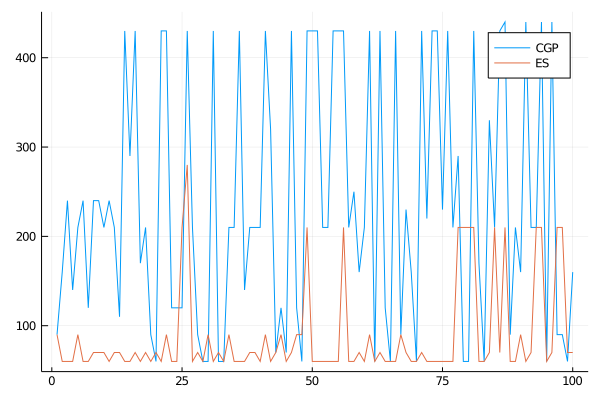

In [64]:
plot(cgp_fits, label="CGP")
plot!(es_fits, label="ES")

Seeing each individual evaluation is useful for understanding our optimization behavior. For example, with CGP, we can note that once it finds a good performing individual, it will test many other individuals which appear to have exactly the same behavior. Furthermore, most CGP mutations greatly decrease the overall fitness, bringing it down to the random action baseline of 60 or 70.

For the neuroevolutionary strategy, we see that it doesn't build well off of previously observed individuals, with many sampled individuals at the random baseline. While the center of the genes is moving along the approximated gradient, the points sampled are chosen randomly and could have very low fitness values.

These sort of insights are useful for improving evolutionary methods. Finally, to better compare the two methods, we'll look at only the maximum fitness found over the entire evolution.

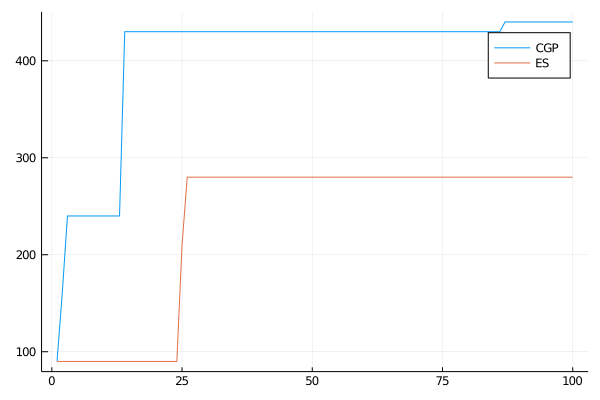

In [66]:
plot(accumulate(max, cgp_fits), label="CGP")
plot!(accumulate(max, es_fits), label="ES")

CGP is a clear winner here, but of course to do a fair comparison, we should run both algorithms multiple times and then compare the average best fitness found and the standard deviation, ideally using a statistical significance test to see if the results are truly different. For environments with a known maximum fitness, the percentage of average evolutions which reach the maximum is also a very useful metric.

<div class="alert alert-info">
    Using the software provided in the project page, experiment with one or multiple evolutionary methods for the evolution of a game-playing agent. In your video presentations, please show and discuss:
    <ul>
        <li>Which evolutionary algorithm was used, with a brief overview of the algorithm</li>
        <li>What, if any, modifications were made to the algorithm</li>
        <li>What algorithm parameters were used and if you experimented with the parameters</li>
        <li>If you compared to a second method, these details about the second method</li>
        <li>Describe the game you were using</li>
        <li>The state, actions, and objective function for the game</li>
        <li>If any behavior characteristic was used, describe it</li>
        <li>The results of evolution showing multiple trials with statistical analysis</li>
        <li>Your interpretation of the results</li>
        <li>Video of your agent playing the game</li>
    </ul>
</div>

As a bonus, let's see an agent that evolved for 10000 generations (to 50000 total evaluations)

In [82]:
using JSON
best = JSON.parsefile("best.dna")
ind = CGPInd(cfg, Float64.(best["chromosome"]));
total_reward, frames = play_atari(ind, render=true)

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/packages/ArcadeLearningEnvironment/YJh2g/src/../deps/roms/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (CCE)
  Cart MD5:  9469d18238345d87768e8965f9f4a6b2
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 9469d18238345d87768e8965f9f4a6b2
Cartridge_name: Ms. Pac-Man (1982) (CCE)

Running ROM file...
Random seed is 0


(5320, Frames{MIME{Symbol("image/png")}}("/tmp/jl_OTHMjQ", 0x0000000000000197, 6.0, nothing))

In [81]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_ZBvvDS", 0x0000000000000197, 6.0, nothing)

Good luck and have fun!

<img src="../imgs/cat.gif" width="30%">